In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
!pip install transformers
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

2.11.0
4.27.4


# 📋 Loading the Data

In [2]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")
#df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')
df = pd.read_csv('/kaggle/input/extended-covid-twitter-datasets/sample_data_only_USA.csv')

In [3]:
df.head()

,created_at,tweet,near,clean_tweet,tokens,lemma,lemma_sentence,pos_tag,lemma_sentence(with POS),sentiword_analysis,vader_score,textblob_polarity,senti_textblob,senti_wordnet,senti_vader
0,2020-08-20,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,United States,no joke hop plane covid lol,"['no', 'joke', 'hop', 'plane', 'covid', 'lol']","['no', 'joke', 'hop', 'plane', 'covid', 'lol']",no joke hop plane covid lol,"[('no', None), ('joke', 'n'), ('hop', 'n'), ('...",no joke hop plane covid lol,0.375,0.2292,0.800000,1,1,1
1,2020-08-20,Coronavirus impact Govt extends I-T deadlines ...,United States,coronavirus impact govt extends deadlines rela...,"['coronavirus', 'impact', 'govt', 'extends', '...","['coronavirus', 'impact', 'govt', 'extends', '...",coronavirus impact govt extends deadline relat...,"[('coronavirus', 'a'), ('impact', 'n'), ('govt...",coronavirus impact govt extend deadline rela...,0.125,0.1779,0.000000,0,1,1
2,2020-08-20,Dear Chinese! Kindly cook your bat thoroughly ...,United States,dear chinese kindly cook bat time covid corona...,"['dear', 'chinese', 'kindly', 'cook', 'bat', '...","['dear', 'chinese', 'kindly', 'cook', 'bat', '...",dear chinese kindly cook bat time covid corona...,"[('dear', 'a'), ('chinese', 'a'), ('kindly', '...",dear chinese kindly cook bat time covid coro...,1.000,0.7003,0.300000,1,1,1
3,2020-08-20,Just heard that my Oncle in France has the Cov...,United States,heard oncle france covid coma critical conditi...,"['heard', 'oncle', 'france', 'covid', 'coma', ...","['heard', 'oncle', 'france', 'covid', 'coma', ...",heard oncle france covid coma critical conditi...,"[('heard', 'a'), ('oncle', 'n'), ('france', 'n...",heard oncle france covid coma critical condi...,-0.125,0.1021,0.133333,1,-1,1
4,2020-08-20,books and wine are two of the greatest pleasur...,United States,books wine greatest pleasures perfect covid st...,"['books', 'wine', 'greatest', 'pleasures', 'pe...","['book', 'wine', 'greatest', 'pleasure', 'perf...",book wine greatest pleasure perfect covid stay...,"[('books', 'n'), ('wine', 'v'), ('greatest', '...",book wine great pleasure perfect covid stay ...,0.000,0.9371,0.766667,1,0,1


In [4]:
df['text'] = df['clean_tweet']
df['target'] = df['senti_textblob']

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [6]:
train2, test2 = train, test

# 🔨 Preprocessing

In [7]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [8]:
seq_len = max([len(text) for text in train['text']]) #256
batch_size = 16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [9]:
size

105

In [10]:
labels.shape

(2400, 3)

# 🤖 Model Building

In [11]:
'''
###### MODEL 1 ####

model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
# embeddings = model.bert(input_ids, attention_mask=mask)[1]
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = embeddings[:, 0, :]
#embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
#x = tf.keras.layers.Dropout(0.1)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layers
# bert_model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)
'''

"\n###### MODEL 1 ####\n\nmodel = TFAutoModel.from_pretrained(model_name)\n\n# Two inputs\ninput_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')\nmask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')\n\n# Transformer\n# embeddings = model.bert(input_ids, attention_mask=mask)[1]\nembeddings = model(input_ids, attention_mask=mask)[0]\nembeddings = embeddings[:, 0, :]\n#embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)\n\n# Classifier head\nx = tf.keras.layers.Dense(512, activation='relu')(embeddings)\n#x = tf.keras.layers.Dropout(0.1)(x)\ny = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)\n\nbert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)\n\n# freeze bert layers\n# bert_model.layers[2].trainable = False\n\noptimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)\nloss = tf.keras.losses.CategoricalCrossentropy()\nacc = tf.keras.metrics.CategoricalAccuracy()\n\nbert_model.compi

In [12]:
'''

### MODEL 2 ####
model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
#embeddings = embeddings[:, 0, :]

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)


bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate= 4e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)
'''

"\n\n### MODEL 2 ####\nmodel = TFAutoModel.from_pretrained(model_name)\n\n# Two inputs\ninput_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')\nmask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')\n\n# Transformer\nembeddings = model(input_ids, attention_mask=mask)[0]\nembeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)\n#embeddings = embeddings[:, 0, :]\n\n# Classifier head\nx = tf.keras.layers.Dense(512, activation='relu')(embeddings)\nx = tf.keras.layers.Dense(256, activation='relu')(x)\nx = tf.keras.layers.Dense(128, activation='relu')(x)\nx = tf.keras.layers.Dropout(0.05)(x)\ny = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)\n\n\nbert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)\n\noptimizer = tf.keras.optimizers.Adam(learning_rate= 4e-5)\nloss = tf.keras.losses.CategoricalCrossentropy()\nacc = tf.keras.metrics.CategoricalAccuracy()\n\nbert_model.compile(optimizer=optimiz

In [13]:
####### MODEL 3 #########
'''
In this example, a BiLSTM layer is added after the Transformer layer. The number of units in the BiLSTM layer is set to 64, 
but you can modify this value based on your specific use case. The output of the BiLSTM layer is passed through two dense layers, 
each with 512 units and a ReLU activation function, before being fed to the classifier head.
'''

bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add a BiLSTM layer
lstm_units = 512 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)
attention_layer = tf.keras.layers.Attention()([lstm, lstm])

# Add Dense layers
#x = tf.keras.layers.Dense(512, activation='relu')(lstm)
x = tf.keras.layers.Dense(512, activation='relu')(attention_layer)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# Flatten the output tensor
x = tf.keras.layers.Flatten()(x)

# Classifier head
outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

# Create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

'''
In the above example, monitor specifies the metric to be monitored for early stopping, 
patience specifies the number of epochs with no improvement after which training will be stopped, 
mode specifies whether the monitored metric should be minimized or maximized, and 
restore_best_weights specifies whether to restore the weights of the model corresponding to the epoch with the best monitored metric value.

Adagrad
Adadelta
RMSprop

1.2277e-05 (best val loss)


import math
# Define the LearningRateScheduler callback
initial_learning_rate = 1e-3
def lr_exp_decay(epoch):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

'''

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop]
    #callbacks=[lr_callback] #
)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 97s 490ms/step - loss: 0.8110 - categorical_accuracy: 0.6911 - val_loss: 0.5681 - val_categorical_accuracy: 0.8194
Epoch 2/50
105/105 [==============================] - 45s 430ms/step - loss: 0.5886 - categorical_accuracy: 0.8065 - val_loss: 0.5183 - val_categorical_accuracy: 0.8444
Epoch 3/50
105/105 [==============================] - 46s 437ms/step - loss: 0.4533 - categorical_accuracy: 0.8595 - val_loss: 0.3446 - val_categorical_accuracy: 0.9083
Epoch 4/50
105/105 [==============================] - 47s 444ms/step - loss: 0.3268 - categorical_accuracy: 0.9000 - val_loss: 0.1803 - val_categorical_accuracy: 0.9556
Epoch 5/50
105/105 [==============================] - 47s 446ms/step - loss: 0.2368 - categorical_accuracy: 0.9304 - val_loss: 0.1453 - val_categorical_accuracy: 0.9556
Epoch 6/50
105/105 [==============================] - 47s 449ms/step - loss: 0.1785 - categorical_accuracy: 0.9524 - val_loss: 0.1351 - val_categorical_acc

# LIME Explainer

In [28]:
# 0 -> Neg, 1 -> Neu, 2 -> Pos
test3 = test[test['target']==2]

In [29]:
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])

0 today feel good corona virus job searching hard mental health
1 sincere condolences roney family devastating news walaceroney paradise covid
2 coronavirus shrink fast kardashian noses pandemic
3 corona virus people horny depressed creative alcoholics big simping
4 family not victim coronavirus ijn amen happy month
5 sarcastic trudeau gov disaster liars trudeau gov allowed coronavirus spread canada
6 breaking number people tested positive corona israel condition died
7 not corona viruse bring mankind not bad people
8 dranbumani medicine covid social distancing pmkcalscurfewextension
9 coronavirus wind april fool days sails mightily impressed hits
10 corona virus april fools prank china tired happy month tho
11 bore watch videos laughs covid stayathome coronavirus aprilfolsday
12 love jail doesnt time limit corona virus miss bestfriend
13 yal canva updated logo looked coronavirus lol
14 covid ends hot town summer city hand hougie tidie
15 threw corona virus party people sft apt ass
16 

In [30]:
idx = 13

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

for ind, (i, row) in enumerate(test3.iterrows()):
    if ind == idx:
        print(row.text)
        tokens = prep_data(row['text'])

# We choose a sample from test set

test_text = np.array(test3['text'])
test_class = np.array(test3['target'])
text_sample = test_text[idx]
class_names = ['Negative','Neutral','Positive']
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])

yal canva updated logo looked coronavirus lol
1/1 [==============================] - 4s 4s/step
Probability = [[0.    0.    0.999]]
True class: Positive


In [31]:
def predict_fn(x):    
    x =  prep_data(x)
    return model.predict(x)

print(text_sample)
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_sample, predict_fn, num_features=12, top_labels=3)
exp.show_in_notebook(text=text_sample)

yal canva updated logo looked coronavirus lol
1/1 [==============================] - 0s 62ms/step
Probability = [[0.    0.    0.999]]
True class: Positive
157/157 [==============================] - 37s 233ms/step


# SHAP Explainer

In [32]:
test3 = test[test['target']==2]
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])

0 today feel good corona virus job searching hard mental health
1 sincere condolences roney family devastating news walaceroney paradise covid
2 coronavirus shrink fast kardashian noses pandemic
3 corona virus people horny depressed creative alcoholics big simping
4 family not victim coronavirus ijn amen happy month
5 sarcastic trudeau gov disaster liars trudeau gov allowed coronavirus spread canada
6 breaking number people tested positive corona israel condition died
7 not corona viruse bring mankind not bad people
8 dranbumani medicine covid social distancing pmkcalscurfewextension
9 coronavirus wind april fool days sails mightily impressed hits
10 corona virus april fools prank china tired happy month tho
11 bore watch videos laughs covid stayathome coronavirus aprilfolsday
12 love jail doesnt time limit corona virus miss bestfriend
13 yal canva updated logo looked coronavirus lol
14 covid ends hot town summer city hand hougie tidie
15 threw corona virus party people sft apt ass
16 

In [33]:
#test3[21:29] negative
#test3[47:54] neutral
test3[19:26] # positive

,text,target,prediction
521,omg guys read cure coronavirus finding girlfri...,2,2
2724,republican boomers coronavirus democratic hoax...,2,1
1842,lol april fools tomorrow coronavirus,2,2
2525,waiting gov corona april fools joke back norma...,2,2
1330,excited kind shit storm april fools corona vir...,2,2
416,persons tested positive covid kashmir today to...,2,2
45,good happening covid make full,2,2


In [34]:
import shap 
import scipy.special

def predictor(x):
    input_ids = tokenizer(x, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')['input_ids']
    attention_mask = tokenizer(x, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')['attention_mask']
    outputs = model.predict([input_ids, attention_mask])
    probas = tf.nn.softmax(outputs).numpy()
    val = scipy.special.logit(probas[:,1])
    return val

def f_batch(x):
    val = np.array([])
    for i in x:
        val = np.append(val, predictor(i))
    return val

explainer_roberta = shap.Explainer(f_batch, tokenizer)

shap_values = explainer_roberta(test3['text'][19:26].tolist())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
1/1 [=======================

  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


Partition explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step


  0%|          | 0/272 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


Partition explainer:  43%|████▎     | 3/7 [00:57<00:52, 13.09s/it]

1/1 [==============================] - 0s 64ms/step


  0%|          | 0/90 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


Partition explainer:  57%|█████▋    | 4/7 [01:06<00:34, 11.48s/it]

1/1 [==============================] - 0s 87ms/step


  0%|          | 0/210 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


Partition explainer:  71%|███████▏  | 5/7 [01:23<00:27, 13.76s/it]

1/1 [==============================] - 0s 62ms/step


  0%|          | 0/182 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


Partition explainer:  86%|████████▌ | 6/7 [01:41<00:15, 15.06s/it]

1/1 [==============================] - 0s 64ms/step


  0%|          | 0/420 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


Partition explainer: 100%|██████████| 7/7 [02:25<00:00, 24.57s/it]

1/1 [==============================] - 0s 62ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


Partition explainer: 8it [02:31, 21.60s/it]                       


In [35]:
shap.plots.text(shap_values)

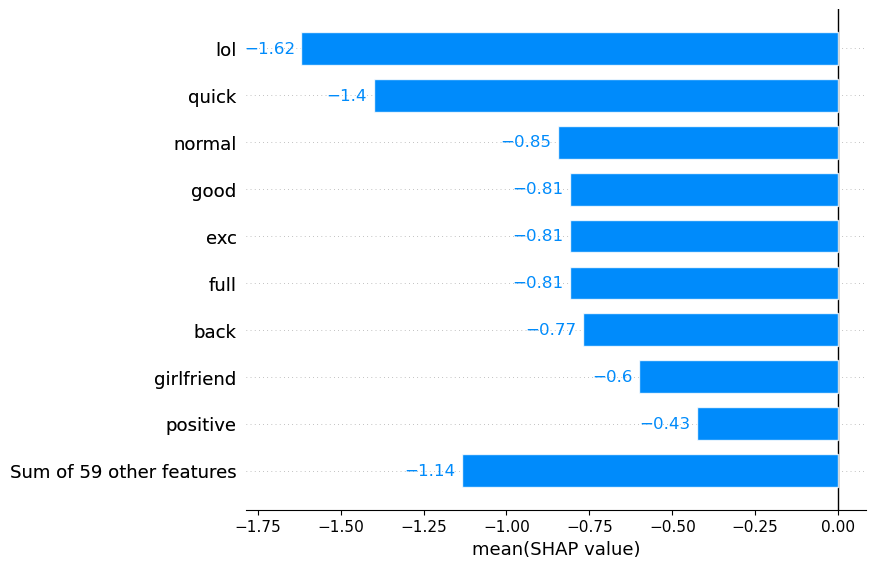

In [36]:
%matplotlib inline
shap.plots.bar(shap_values.mean(0))
plt.show()

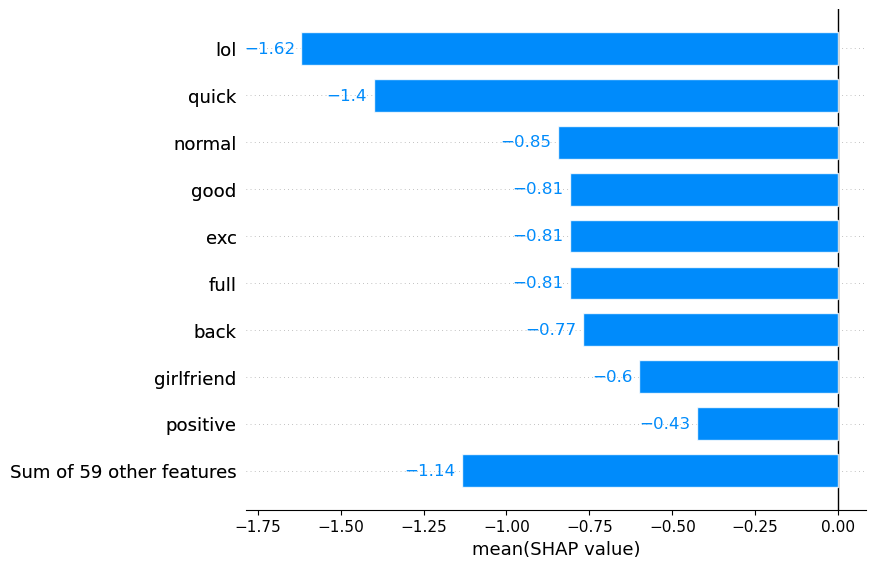

In [37]:
# we can sort the bar chart in decending order
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort)

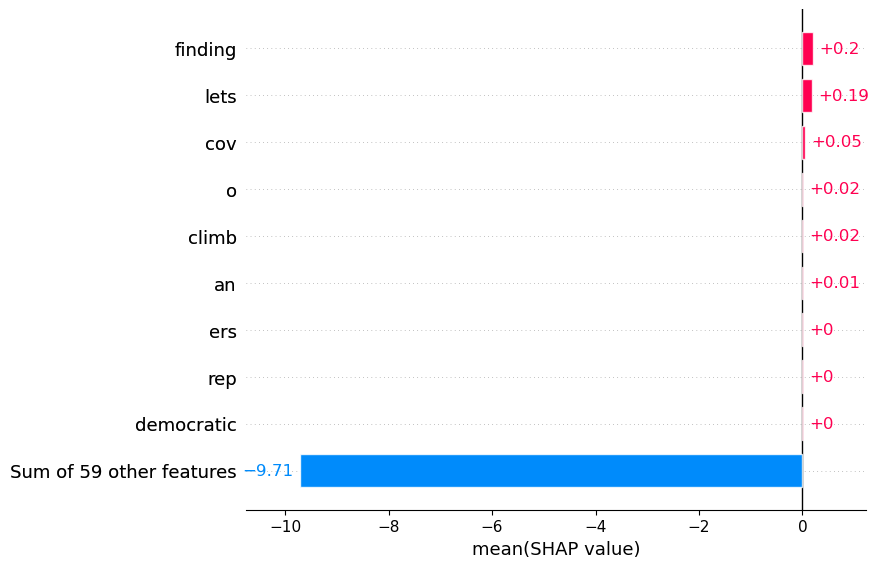

In [38]:
# ...or acending order
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort.flip)

# Model Architecture

In [19]:
'''
import matplotlib.pyplot as plt

# Plot the learning rate schedule
plt.figure(figsize=(8, 6))
lrs = [lr_exp_decay(epoch) for epoch in range(50)]
plt.plot(lrs, '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.title('Learning Rate vs Epoch')
plt.xlabel('Epoch')  ## Epoch vs Learning rate
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('lr_vs_epoch.png')

# Plot the loss versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['val_loss'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss vs Learning Rate')
plt.savefig('val_loss_vs_lr.png')

# Plot the loss versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['loss'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss vs Learning Rate')
plt.savefig('train_loss_vs_lr.png')

# Plot the accuracy versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['categorical_accuracy'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Training Accuracy')
plt.legend()
plt.title('Training Accuracy vs Learning Rate')
plt.savefig('train_acc_vs_lr.png')

# Plot the accuracy versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['val_categorical_accuracy'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Learning Rate')
plt.savefig('val_acc_vs_lr.png')
'''

"\nimport matplotlib.pyplot as plt\n\n# Plot the learning rate schedule\nplt.figure(figsize=(8, 6))\nlrs = [lr_exp_decay(epoch) for epoch in range(50)]\nplt.plot(lrs, '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')\nplt.title('Learning Rate vs Epoch')\nplt.xlabel('Epoch')  ## Epoch vs Learning rate\nplt.ylabel('Learning Rate')\nplt.legend()\nplt.savefig('lr_vs_epoch.png')\n\n# Plot the loss versus learning rate\nplt.figure(figsize=(8, 6))\nplt.plot(lrs, history.history['val_loss'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')\nplt.xscale('log')\nplt.xlabel('Learning Rate (log)')\nplt.ylabel('Validation Loss')\nplt.legend()\nplt.title('Validation Loss vs Learning Rate')\nplt.savefig('val_loss_vs_lr.png')\n\n# Plot the loss versus learning rate\nplt.figure(figsize=(8, 6))\nplt.plot(lrs, history.history['loss'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')\nplt.xscale('log')\nplt.xlabel('Learning Rate (log)')\nplt.ylabel('Training Loss')\nplt.legend()\nplt.ti

In [22]:
'''
# Find the best learning rate based on the validation loss
val_losses = history.history['val_loss']
best_lr_idx = val_losses.index(min(val_losses))
best_lr = lr_exp_decay(best_lr_idx)
print('Best Learning Rate:', best_lr)
'''

"\n# Find the best learning rate based on the validation loss\nval_losses = history.history['val_loss']\nbest_lr_idx = val_losses.index(min(val_losses))\nbest_lr = lr_exp_decay(best_lr_idx)\nprint('Best Learning Rate:', best_lr)\n"

In [14]:
bert_model = model

In [15]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 115)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 115)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 115,                                           

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


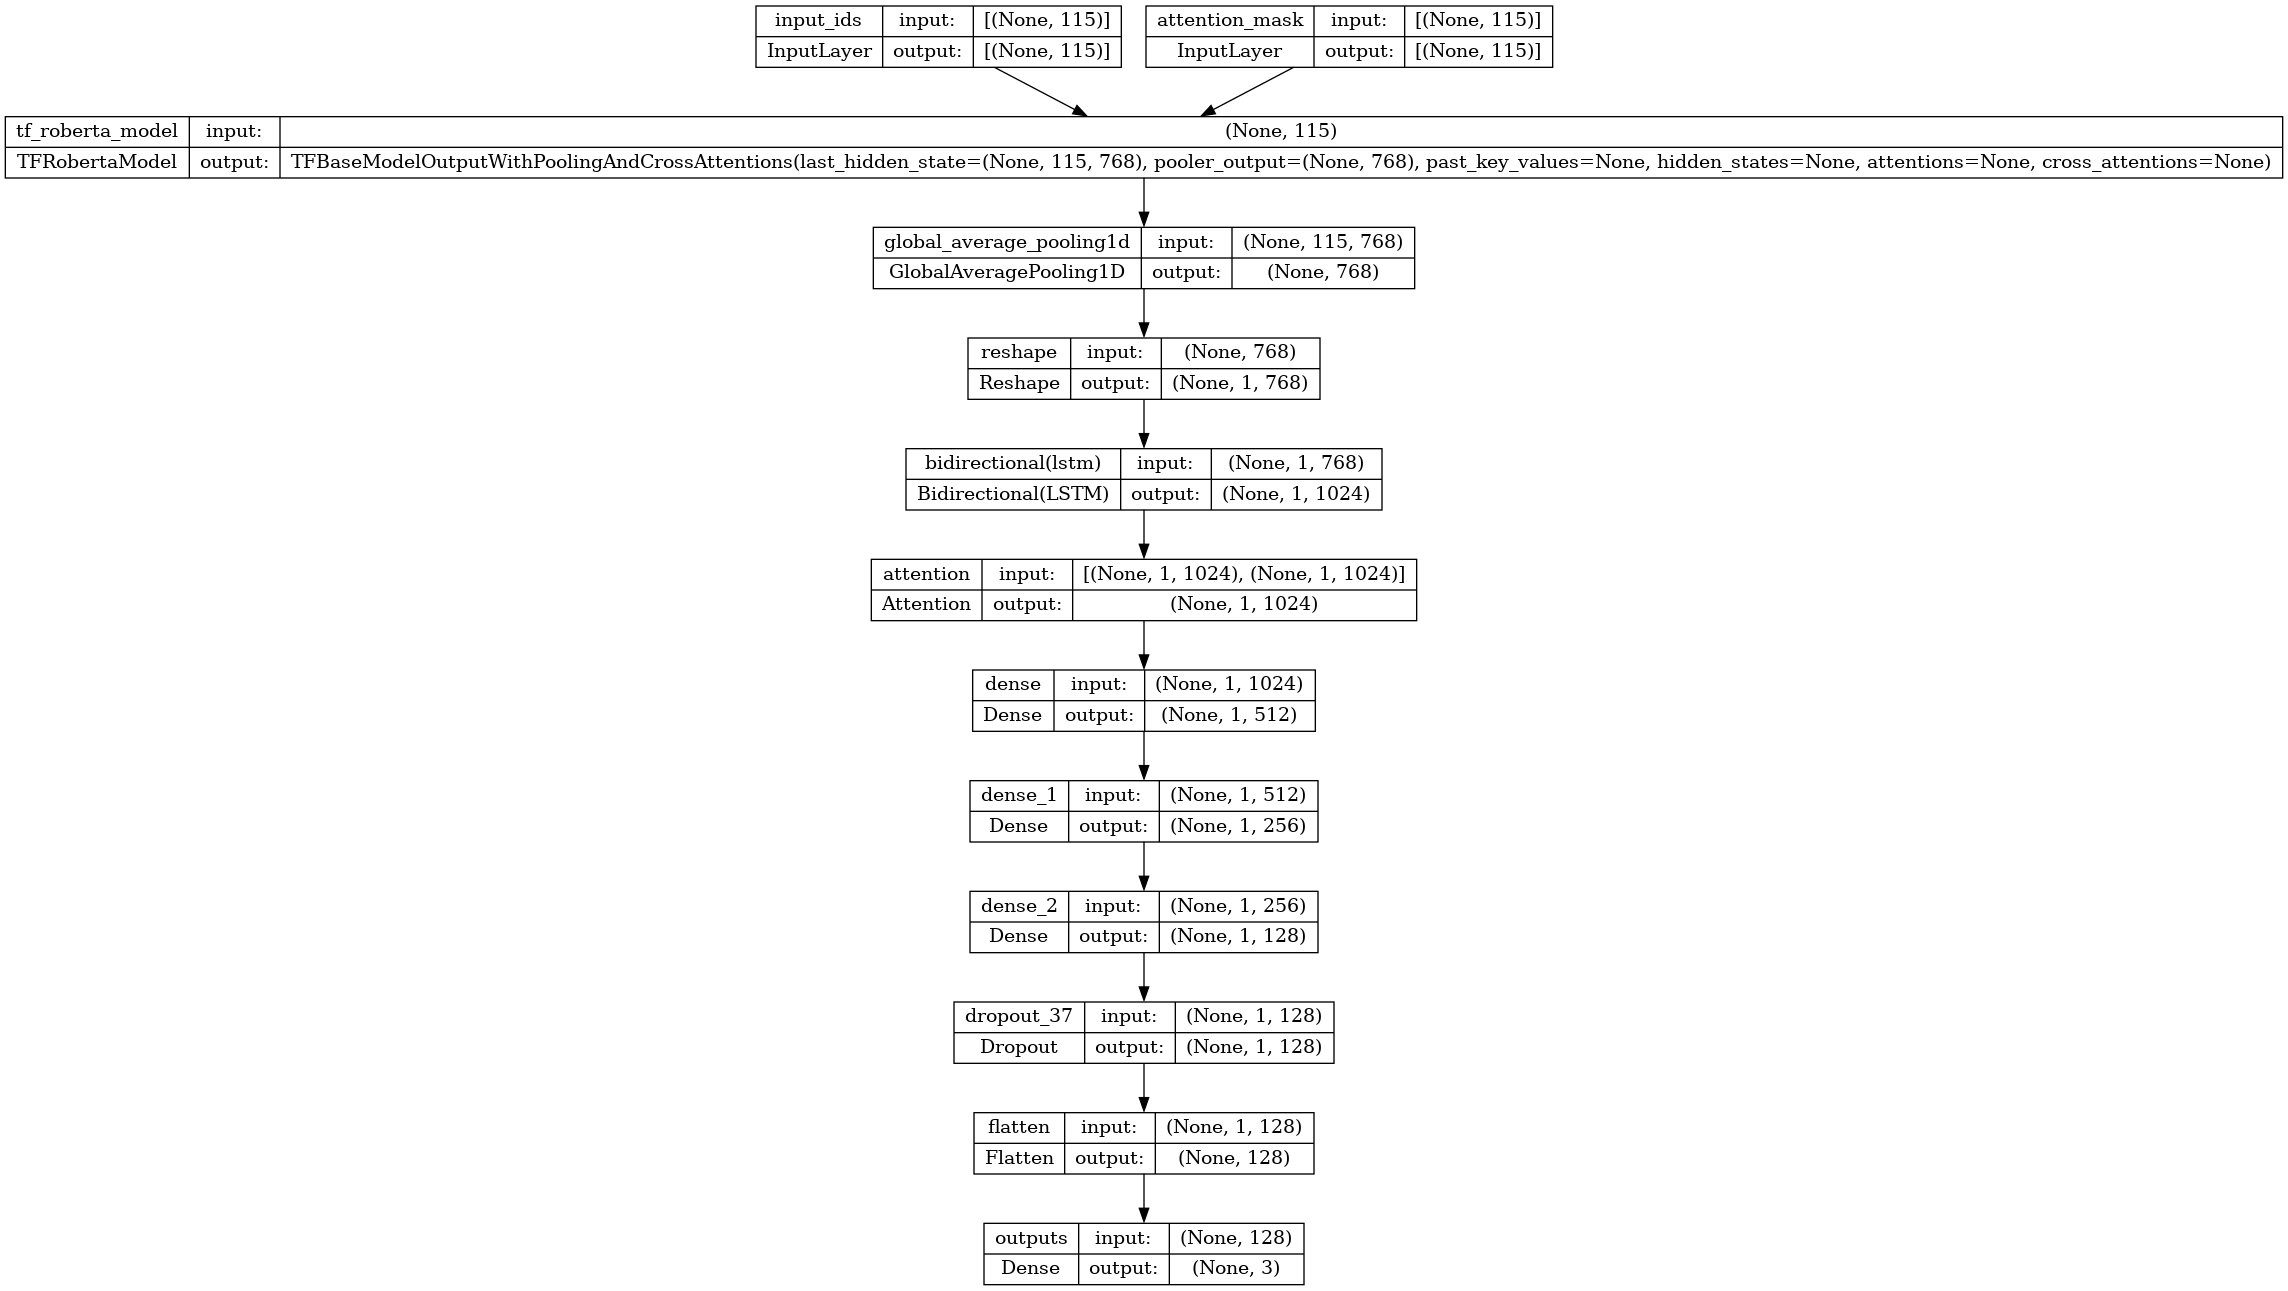

In [16]:
tf.keras.utils.plot_model(bert_model, to_file = 'bert_model1.png', show_shapes=True, show_layer_names = True)

# 📊 Model Evaluation

In [17]:
# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import wordcloud

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

In [18]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss1.png')
    
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(r.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy1.png')

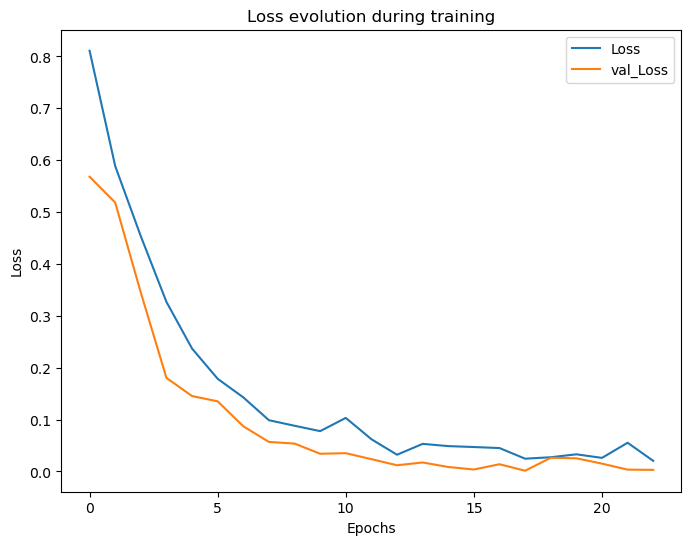

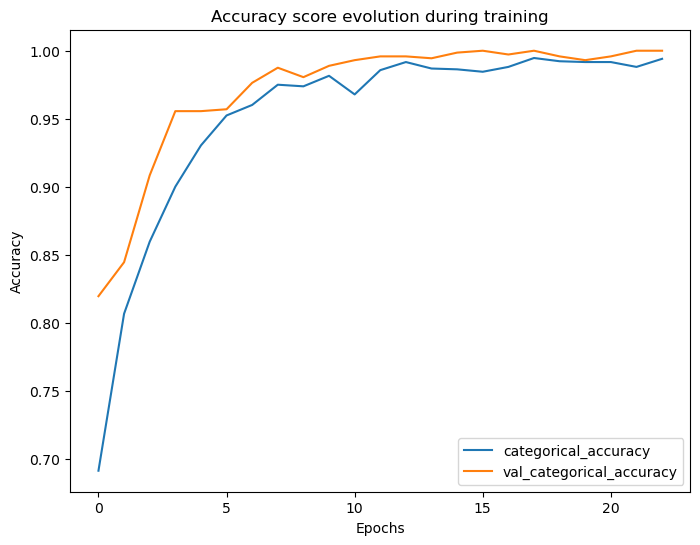

In [19]:
plot_learning_evolution(history)

In [20]:
bert_model.evaluate(val_ds)

45/45 [==============================] - 6s 122ms/step - loss: 0.0019 - categorical_accuracy: 1.0000


[0.001946005504578352, 1.0]

In [21]:
bert_model.evaluate(train_ds)

105/105 [==============================] - 13s 122ms/step - loss: 0.0061 - categorical_accuracy: 0.9982


[0.0061258962377905846, 0.9982143044471741]

In [22]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)
test

,text,target,prediction
1801,dont coronavirus pranks shit lame,0,0
1190,corona virus tiger king throwing words wall ru...,1,1
1817,trumps lie hes corona whisperer acted guess maga,1,1
251,no conspiracy theorist carol baskin coronaviru...,1,1
2505,girls slut shame appeared undercover hoes coro...,1,1
...,...,...,...
104,corona control encourage cottage industries re...,1,1
2087,die coronavirus lucky,2,2
599,chest pain call covid free toll number kana ik...,2,2
1756,corona virus technology,1,1


In [23]:
labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

              precision    recall  f1-score   support

    Negative       0.81      0.82      0.82       130
     Neutral       0.90      0.88      0.89       303
    Positive       0.84      0.86      0.85       167

    accuracy                           0.86       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.86      0.86       600



In [24]:
test.head()

,text,target,prediction
1801,dont coronavirus pranks shit lame,0,0
1190,corona virus tiger king throwing words wall ru...,1,1
1817,trumps lie hes corona whisperer acted guess maga,1,1
251,no conspiracy theorist carol baskin coronaviru...,1,1
2505,girls slut shame appeared undercover hoes coro...,1,1


In [25]:
test.target.value_counts()

1    303
2    167
0    130
Name: target, dtype: int64

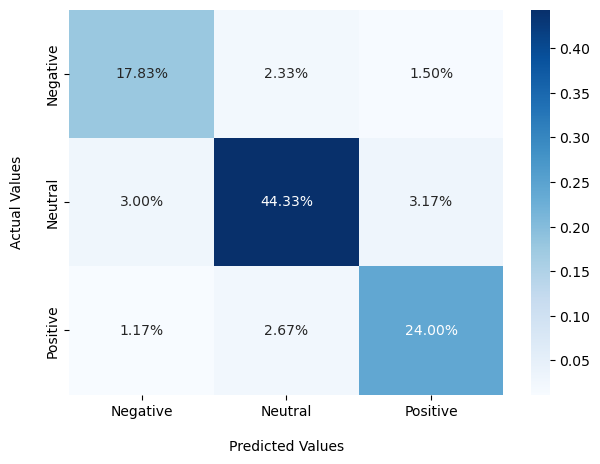

In [26]:
from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

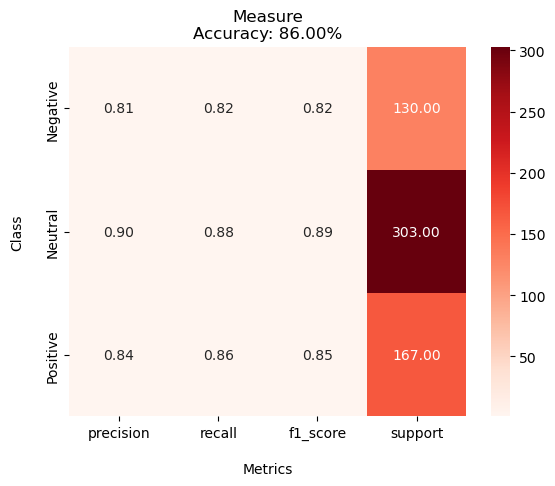

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()
